# Quasi static forces from model test

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.nonlinear_vmm_equations as eq
import src.linear_vmm_equations as eq_linear

import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [2]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

where $Y_{qs}$ is the quasi static force that can be obtained from the model tests as:

In [4]:
Y_eq = eq.Y_eom.subs(eq.Y_nonlin,sp.solve(eq.fy_eq,Y_nonlin)[0])
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [5]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [6]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [7]:
X_eq = eq.X_eom.subs(eq.X_nonlin,sp.solve(eq.fx_eq,X_nonlin)[0])

eq_X_qs = sp.Eq(X_qs,
      sp.solve(X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [8]:
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [9]:
N_eq = eq.N_eom.subs(eq.N_nonlin,sp.solve(eq.mz_eq,N_nonlin)[0])

eq_N_qs = sp.Eq(N_qs,
      sp.solve(N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [10]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [11]:
df_runs = mdl.runs()

In [12]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

In [13]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [14]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890,0.000007,0.932272
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859,0.000007,0.921355
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860,-0.000000,0.921396
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969,-0.000000,0.923933
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948,-0.000000,0.924786


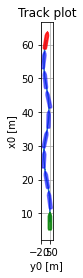

In [15]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [16]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [17]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [18]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','brix_prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/2  # Just guessing
df_parameters['brix_prime'].fillna(0, inplace=True)

In [19]:
df_parameters['brix_prime']

Xudot               0.000179
Xvdot               0.000000
Xrdot               0.000000
Yudot               0.000000
Yvdot              -0.006109
Yrdot              -0.000303
Nudot               0.000000
Nvdot              -0.000128
Nrdot              -0.000299
Xu                  0.000000
Xv                  0.000000
Xr                  0.000000
Xdelta              0.000000
Xuu                 0.000000
Xuv                 0.000000
Xur                 0.000000
Xudelta             0.000000
Xvv                 0.000000
Xvr                 0.000000
Xvdelta             0.000000
Xrr                 0.000000
Xrdelta             0.000000
Xdeltadelta         0.000000
Xuuu                0.000000
Xuuv                0.000000
Xuur                0.000000
Xuudelta            0.000000
Xuvv                0.000000
Xuvr                0.000000
Xuvdelta            0.000000
Xurr                0.000000
Xurdelta            0.000000
Xudeltadelta        0.000000
Xvvv                0.000000
Xvvr          

In [20]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['X_qs'] = run(X_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['N_qs'] = run(N_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])

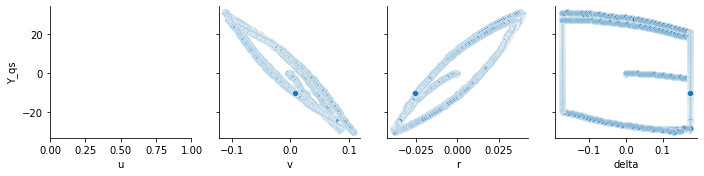

In [21]:
g = sns.PairGrid(df, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

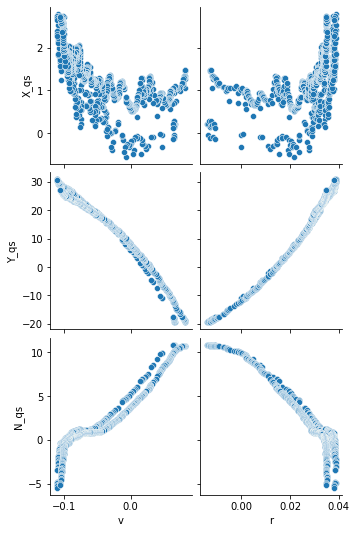

In [22]:
mask = df['delta'] <= df['delta'].quantile(q=0.01)
df_min = df.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:xlabel='time'>

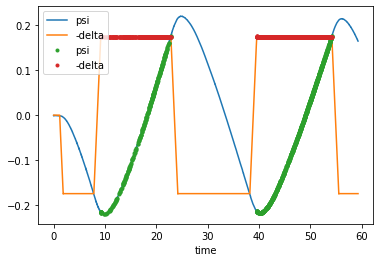

In [23]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_min.plot(y=['psi','-delta'], style='.', ax=ax)

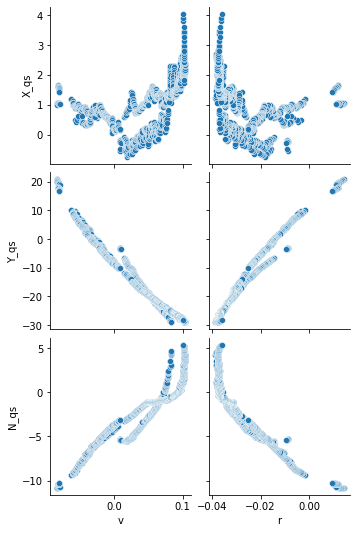

In [24]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:xlabel='time'>

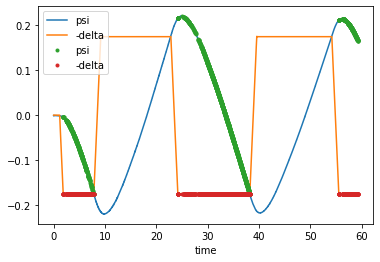

In [25]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_max.plot(y=['psi','-delta'], style='.', ax=ax)

# Regression (linear model)

## N

In [26]:
Math(vlatex(eq_linear.N_qs_eq))

<IPython.core.display.Math object>

In [27]:
interesting = ['u','v','r','delta','X_qs','Y_qs','N_qs']
df_prime = ps.prime(df[interesting], U=df['V'])

In [28]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq_linear.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [29]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{delta}],
[    N_{r}],
[    N_{u}],
[    N_{v}]]))

In [30]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [31]:
diff_eq_N.eq_y

Eq(y, N_)

In [32]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [33]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          3.029e+04
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        11:09:30   Log-Likelihood:                          55740.
No. Observations:                5927   AIC:                                 -1.115e+05
Df Residuals:                    5923   BIC:                                 -1.114e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0009   6.15e-06   -138.285      0.000      -0.001      -0.001
Nr            -0.0005   1.11e-05    -46.367      0.000      -0.001      -0.000
Nu          2.429e-08   2.69e-07      0.090      0.928   -5.02e-07    5.51e-07
Nv             0.0006    1.4e-05     44.088      0.000       0.001       0.001
==============================================================================
Omnibus:                      320.038   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1272.539
Skew:                          -0.043   Prob(JB):                    4.70e-277
Kurtosis:                       5.268   Cond. No.                         71.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

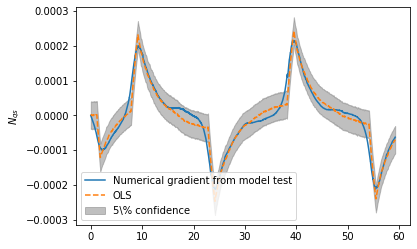

In [34]:
X = diff_eq_N.calculate_features(data=df_prime)
y = diff_eq_N.calculate_label(y=df_prime['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [35]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq_linear.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.714e+06
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        11:09:31   Log-Likelihood:                          50880.
No. Observations:                5927   AIC:                                 -1.018e+05
Df Residuals:                    5923   BIC:                                 -1.017e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0021    1.4e-05    146.810      0.000       0.002       0.002
Yr             0.0091   2.52e-05    359.600      0.000       0.009       0.009
Yu         -2.404e-05    6.1e-07    -39.420      0.000   -2.52e-05   -2.28e-05
Yv            -0.0110   3.17e-05   -346.131      0.000      -0.011      -0.011
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                1.232
Skew:                           0.034   Prob(JB):                        0.540
Kurtosis:                       2.984   Cond. No.                         71.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

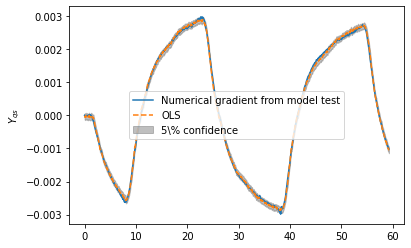

In [36]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = diff_eq_Y.calculate_label(y=df_prime['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [37]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq_linear.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   X_qs   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              2775.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        11:09:31   Log-Likelihood:                          47835.
No. Observations:                5927   AIC:                                 -9.566e+04
Df Residuals:                    5923   BIC:                                 -9.563e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta        -0.0002   2.34e-05     -7.641      0.000      -0.000      -0.000
Xr            -0.0003   4.21e-05     -7.833      0.000      -0.000      -0.000
Xu          9.731e-05   1.02e-06     95.462      0.000    9.53e-05    9.93e-05
Xv            -0.0006    5.3e-05    -12.071      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      371.885   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.730
Skew:                           0.534   Prob(JB):                    7.00e-120
Kurtosis:                       4.041   Cond. No.                         71.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

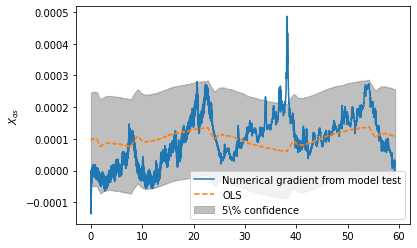

In [38]:
X = diff_eq_X.calculate_features(data=df_prime)
y = diff_eq_X.calculate_label(y=df_prime['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [39]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [40]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [41]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,0.000000e+00,-8.388476e-04,-8.629731e-04,NaN,-0.002500,-8.509103e-04,delta,N,,N_{delta},-8.509103e-04
Ndeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,N,,N_{deltadelta},0.000000e+00
Ndeltadeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,deltadeltadelta,N,,N_{deltadeltadelta},0.000000e+00
Nr,0.000000e+00,-4.929635e-04,-5.364877e-04,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-5.147256e-04,r,N,,N_{r},-5.147256e-04
Nrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,N,,N_{rdelta},0.000000e+00
Nrdeltadelta,NaN,NaN,NaN,NaN,0.000000,NaN,rdeltadelta,N,,N_{rdeltadelta},0.000000e+00
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-2.986748e-04
Nrr,NaN,NaN,NaN,NaN,0.000000,NaN,rr,N,,N_{rr},0.000000e+00
Nrrdelta,NaN,NaN,NaN,NaN,0.000000,NaN,rrdelta,N,,N_{rrdelta},0.000000e+00
Nrrr,NaN,NaN,NaN,NaN,0.000000,NaN,rrr,N,,N_{rrr},0.000000e+00


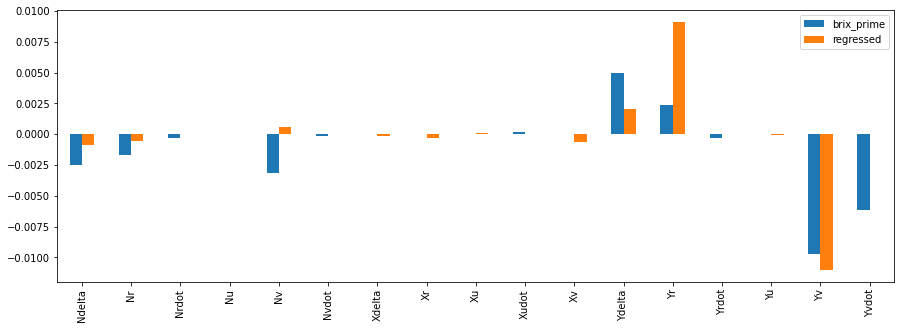

In [42]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
mask = ((df_parameters_all['brix_prime'] != 0) |
        (df_parameters_all['regressed']).notnull())
        
df_parameters_plot = df_parameters_all.loc[mask]
df_parameters_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

# Simulate captive

In [43]:
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [44]:
df_prime['X_qs_pred'] = run(function=X_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['N_qs_pred'] = run(function=N_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])


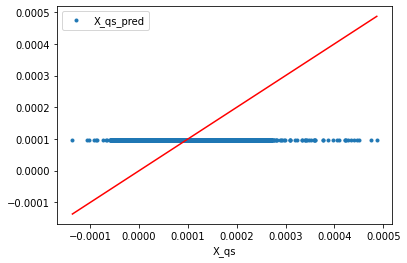

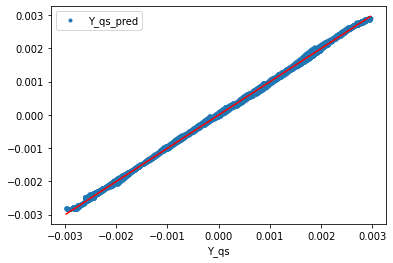

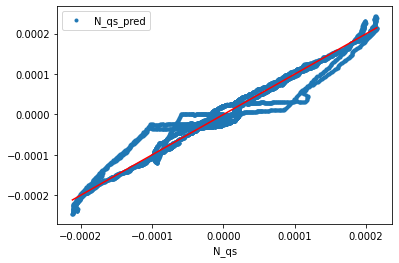

In [45]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    df_prime.plot(x=key, y=f'{key}_pred',style='.', ax=ax)
    ax.plot([df_prime[key].min(), df_prime[key].max()], [df_prime[key].min(), df_prime[key].max()], 'r-')

# Simulation

In [53]:
df_prime['U'] = np.sqrt(df_prime['u']**2 + df_prime['v']**2)
df_prime['t'] = df_prime.index
df_prime['t'] = ps.prime(df_prime[['t']], U=df['V'])
df_prime.head()

,u,v,r,delta,X_qs,Y_qs,N_qs,X_qs_pred,Y_qs_pred,N_qs_pred,U,t
time,,,,,,,,,,,,
0.000000,1.0,0.000890,0.000006,-0.000007,2.135722e-07,1.363354e-08,-5.672013e-08,0.000097,-0.000010,5.510158e-07,1.0,0.000000
0.010007,1.0,0.000859,-0.000135,-0.000007,-9.324590e-05,-1.641077e-06,-3.116600e-07,0.000097,-0.000011,6.042855e-07,1.0,0.001839
0.020011,1.0,0.000860,-0.000713,0.000000,-1.366234e-04,-6.112324e-06,-7.017417e-07,0.000097,-0.000016,8.965119e-07,1.0,0.003677
0.030001,1.0,0.000969,-0.001034,0.000000,-1.065192e-04,-8.881004e-06,-1.455945e-06,0.000097,-0.000020,1.129201e-06,1.0,0.005528
0.040001,1.0,0.000948,-0.000988,0.000000,-8.842642e-05,-8.857667e-06,-1.932673e-06,0.000097,-0.000019,1.091988e-06,1.0,0.007377


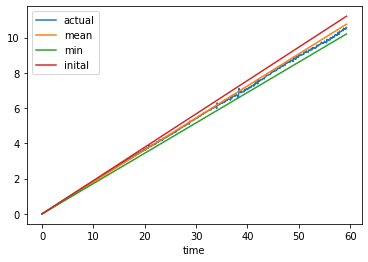

In [75]:
fig,ax=plt.subplots()
df_prime.plot(y='t', ax=ax, label='actual')
ax.plot(df.index, df.index/(ship_parameters['L']/df['V'].mean()), label='mean')
ax.plot(df.index, df.index/(ship_parameters['L']/df['V'].min()), label='min')
ax.plot(df.index, df.index/(ship_parameters['L']/np.sqrt(df_0['u']**2 + df_0['v']**2)), label='inital')
ax.legend()

<AxesSubplot:xlabel='time'>

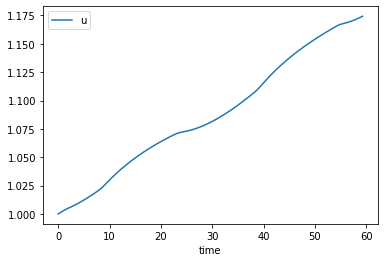

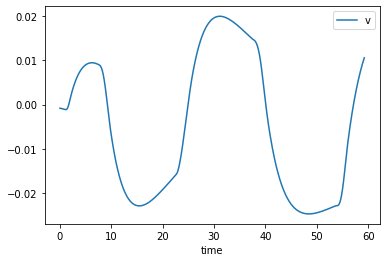

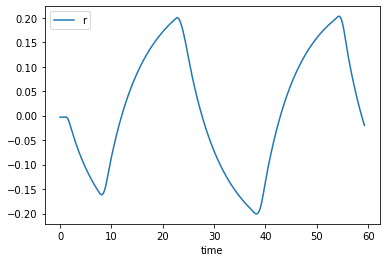

In [62]:
df_ = df.copy()
t = df_.index
control = df_[['delta']]
#control = {'delta':0,}

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi'],
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)

columns = list(y0.keys())
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')


In [71]:
U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
#U_ = df['V'].mean()

df_result = ps.unprime(values=df_result_prime, U=U_)
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

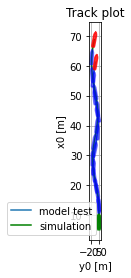

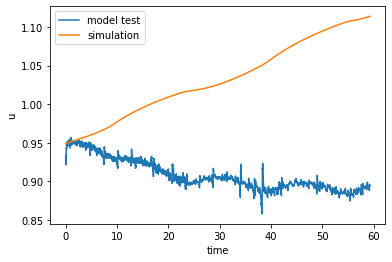

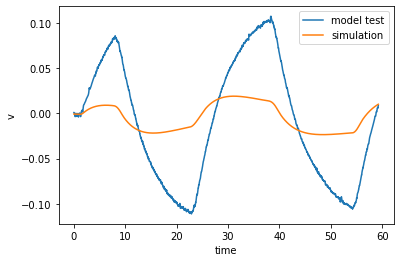

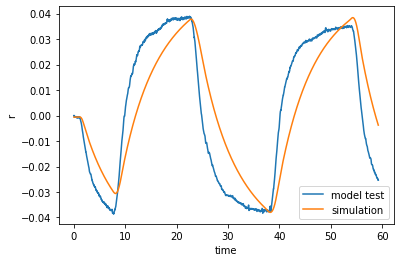

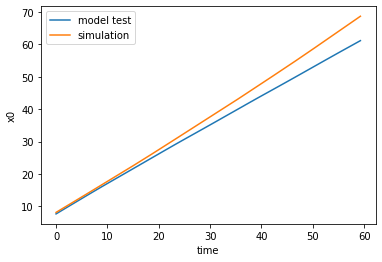

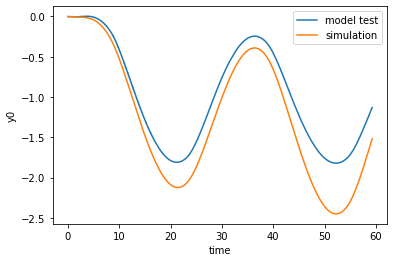

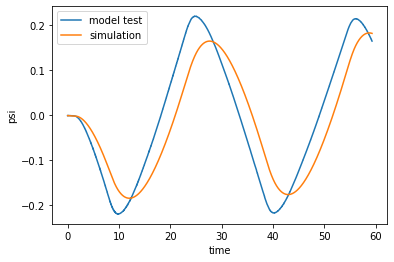

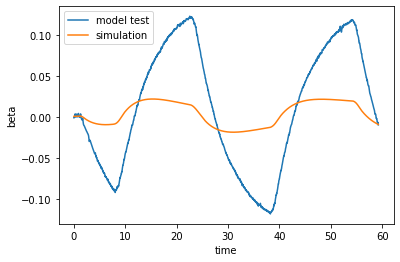

In [72]:
fig,ax=plt.subplots()
track_plot(df=df, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)



<ipython-input-68-1b5b1f6b0b24>:12: RuntimeWarning: invalid value encountered in true_divide
  U_ = t_/t_prime*L_


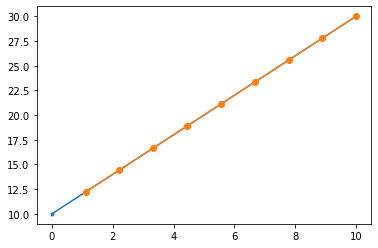

In [68]:
t_ = np.linspace(0,10,10)
L_ = 2
u0_ = 10
k_ = 2
u_ = u0_ + k_*t_ 

u_prime = u_/u_
t_prime = t_/(u_/L_)
#t_prime = t/(U/L)
#--> U = t/t_prime*L

U_ = t_/t_prime*L_
u_unprime = u_prime*U_


fig,ax=plt.subplots()
ax.plot(t_,u_,'.-')
ax.plot(t_,u_unprime,'o-')

